
# Lab 05 – Chihuahua vs Muffin Classifier (CNN, PyTorch)

**Student:** Jose Tuozzo

**Course:** ITAI-1378  
**Notebook name for submission:** `Lab05_CNN_Chihuahua_Muffin.ipynb`

> Run this notebook top-to-bottom. If you are in **Google Colab**, use `Runtime > Run all`.  
> If any library is missing (e.g., `torchsummary`), the notebook tries to install it.


## 1) Setup and Repository Clone

In [2]:

# If you're in Colab, this will clone the repo that contains the data folder.
!git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git || echo "Repo may already exist"
%cd workshop-chihuahua-vs-muffin
!ls -la


Cloning into 'workshop-chihuahua-vs-muffin'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 337 (delta 1), reused 4 (delta 1), pack-reused 330 (from 1)
Receiving objects: 100% (337/337), 14.51 MiB | 32.73 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/workshop-chihuahua-vs-muffin
total 2520
drwxr-xr-x 5 root root    4096 Sep 24 15:32  .
drwxr-xr-x 1 root root    4096 Sep 24 15:32  ..
-rw-r--r-- 1 root root   22769 Sep 24 15:32 'CNN_1 Chihuahua or Muffin.ipynb'
drwxr-xr-x 4 root root    4096 Sep 24 15:32  data
drwxr-xr-x 8 root root    4096 Sep 24 15:32  .git
-rw-r--r-- 1 root root      32 Sep 24 15:32  .gitignore
-rw-r--r-- 1 root root    1839 Sep 24 15:32  README.md
drwxr-xr-x 2 root root    4096 Sep 24 15:32  resources
-rw-r--r-- 1 root root   22093 Sep 24 15:32  workshop_1.ipynb
-rw-r--r-- 1 root root 2502247 Sep 24 15:32  workshop_1_output.ipynb


**Observations — 1) Setup and Repository Clone**

- The repo contains a fixed data/ split. Why this matters: It avoids accidental
leakage between training/validation sets and makes results comparable across runs.

- How to check: Confirm that there are no overlapping filenames/hashes across train/ and validation/. If in doubt, compute a quick SHA1 list to ensure uniqueness.

- Working directory consistency is critical in Colab. Why: restarting the runtime resets your CWD and unmounts drives; relative paths then fail.

- What to do: print os.getcwd() after %cd ...; add a guard that raises if data/ is missing to fail fast.



## 2) Imports & Device

In [3]:

import sys, os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

try:
    from tqdm import tqdm
except Exception as e:
    !pip -q install tqdm
    from tqdm import tqdm

# Optional model summary utility (will try to install if not available)
try:
    from torchsummary import summary
    _HAS_TORCHSUMMARY = True
except Exception:
    _HAS_TORCHSUMMARY = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Torch version:", torch.__version__)


Using device: cpu
Torch version: 2.8.0+cu126


**Observations — 2) Imports & Device**

- Recording torch.version and device documents your compute context. Why: reproducibility—accuracy and speed can shift across CUDA/cuDNN versions.

- What to do: log torch.backends.cudnn.benchmark and deterministic flags if you care about exact reproducibility.

- No global seed is set. Why: augmentation + shuffling introduce stochasticity; small datasets can swing a few points.

- What to do: set seeds to stabilize baselines:

import random, numpy as np, torch
random.seed(42); np.random.seed(42); torch.manual_seed(42); torch.cuda.manual_seed_all(42)


## 3) Data Preparation – Inspect train/validation splits

In [4]:

# Expecting this structure inside ./data:
# data/
#   train/
#     chihuahua/
#     muffin/
#   validation/
#     chihuahua/
#     muffin/

if not os.path.exists("data"):
    raise FileNotFoundError("Expected a 'data' folder inside the repo with train/validation subfolders.")

print("Root contents:", os.listdir("."))
print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

train_chihuahuas = len(os.listdir("data/train/chihuahua"))
train_muffins = len(os.listdir("data/train/muffin"))
val_chihuahuas = len(os.listdir("data/validation/chihuahua"))
val_muffins = len(os.listdir("data/validation/muffin"))

print(f"Training set: {train_chihuahuas} Chihuahuas, {train_muffins} Muffins")
print(f"Validation set: {val_chihuahuas} Chihuahuas, {val_muffins} Muffins")


Root contents: ['.gitignore', 'README.md', '.git', 'workshop_1.ipynb', 'workshop_1_output.ipynb', 'resources', 'CNN_1 Chihuahua or Muffin.ipynb', 'data']
Data contents: ['validation', 'train']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']
Training set: 65 Chihuahuas, 55 Muffins
Validation set: 17 Chihuahuas, 13 Muffins


**Observations — 3) Data Preparation – Inspect train/validation splits**

- Class balance impacts the loss landscape. Why: with imbalance, CrossEntropy can overfit to the majority class and still show “good” accuracy.

- What to do: write down exact counts; if imbalance > ~60/40, consider class weights or focal loss; also report precision/recall per class.

- Directory-based labels (ImageFolder) are robust and human-auditable. Why: errors are visible on disk, not hidden in CSVs; easier to fix mislabels.

- Sanity check: spot-check 10–20 images per class; in this task, texture collisions (crumbs vs fur) are a known pitfall.

## 3.1) Transforms & Dataloaders

In [5]:

# Define image dimensions (replacing the ? ? from the template)
input_height, input_width = 128, 128

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((input_height, input_width)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((input_height, input_width)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': datasets.ImageFolder('data/validation', data_transforms['validation'])
}

batch_size = 32
# num_workers=2 for Colab stability; feel free to set to 4 on local
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available()),
    'validation': DataLoader(image_datasets['validation'], batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
}

num_classes = len(image_datasets['train'].classes)
class_names = image_datasets['train'].classes
print("Classes:", class_names)
print(f"Training samples: {len(image_datasets['train'])}")
print(f"Validation samples: {len(image_datasets['validation'])}")


Classes: ['chihuahua', 'muffin']
Training samples: 120
Validation samples: 30


**Observations — 3.1) Transforms & Dataloaders**

- Input size 128×128 is a compute/accuracy trade-off. Why: larger inputs (e.g., 224×224) increase receptive detail and can reduce texture confusion but raise memory/time ~quadratically.

- Actionable: start at 128×128; if validation plateaus early, try 160–192; if you later use transfer learning, prefer 224.

- ImageNet normalization even for scratch training. Why: centering/scaling accelerates optimization (smoother gradients) and aligns with potential future fine-tuning on pretrained backbones.

- Even better: compute dataset-specific mean/std to match your distribution.

- Augmentations (flip/rotation) target invariances likely in the task. Why: muffins and dogs vary in pose/orientation; encouraging invariance reduces overfitting to pose.

- Next: add ColorJitter (brightness/contrast) to decouple chocolate chips vs eyes; use moderate ranges to avoid label shift.

- num_workers and pin_memory feed the GPU efficiently. Why: I/O bottlenecks inflate epoch time and can destabilize timings when comparing configs.

## 4) Model Definition – ChihuahuaMuffinCNN

In [6]:

class ChihuahuaMuffinCNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * (input_height//8) * (input_width//8), 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = ChihuahuaMuffinCNN().to(device)
print(model)

if '_HAS_TORCHSUMMARY' in globals() and _HAS_TORCHSUMMARY:
    try:
        summary(model, (3, input_height, input_width))
    except Exception as e:
        print("torchsummary available but failed to summarize:", e)
else:
    print("torchsummary not installed; skipping model summary.")


ChihuahuaMuffinCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=2, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
              ReLU-

**Observations — 4) Model Definition – ChihuahuaMuffinCNN**

- Three conv+pool blocks (32→64→128) create hierarchical features. Why: early layers capture edges; mid capture textures; deeper combine shapes—exactly the confusion boundary here (fur vs crumbs).

- The linear layer size scales with input² (128 * (H/8) * (W/8)). Why it matters: parameter count explodes with bigger images, increasing overfitting risk on small data.

- Alternative: replace flatten+linear with GlobalAveragePooling + small MLP; this decouples parameters from spatial size and often generalizes better.

- Dropout(0.5) fights co-adaptation. Why: with small datasets, it’s a strong regularizer; but too much can underfit.

- Tuning tip: if val acc lags train acc by >10–15 pts, raise dropout; if both are low, reduce slightly or add BatchNorm.

- Consider BatchNorm after each conv. Why: it stabilizes training by normalizing internal covariate shift, enabling slightly higher learning rates.

## 5) Training Setup – Loss & Optimizer

In [7]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print("Loss function:", criterion)
print("Optimizer:", optimizer)


Loss function: CrossEntropyLoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


**Observations — 5) Training Setup – Loss & Optimizer**

- CrossEntropyLoss assumes well-calibrated logits. Why: poor calibration can yield good accuracy but unreliable confidence (important for error analysis).

- Improvement: try label smoothing (e.g., CrossEntropyLoss(label_smoothing=0.05)) to reduce overconfidence.

- Adam (lr=1e-3) converges fast on small CNNs. Why: adaptive updates shine with heterogeneous gradients in early layers.

- Generalization note: for the final tuned model, SGD+momentum sometimes generalizes better; start with Adam, then try SGD (lr ~0.05–0.1 with cosine/scheduler).

- Weight decay combats weight explosion. Why: it regularizes all layers uniformly; start with weight_decay=1e-4 for Adam when you see val loss rising while train loss falls.

## 6) Training Loop

In [8]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*20)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss, running_corrects = 0.0, 0
            dataset_size = len(image_datasets[phase])

            for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_size
            epoch_acc = running_corrects.double().item() / dataset_size
            print(f"{phase} Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
        print()
    return model, history

trained_model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
print("Training complete!")


Epoch 1/10
--------------------


train: 100%|██████████| 4/4 [00:07<00:00,  1.75s/it]


train Loss: 2.3094  Acc: 0.4167


validation: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


validation Loss: 0.6590  Acc: 0.5667

Epoch 2/10
--------------------


train: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it]


train Loss: 0.6613  Acc: 0.6667


validation: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


validation Loss: 0.6817  Acc: 0.5667

Epoch 3/10
--------------------


train: 100%|██████████| 4/4 [00:07<00:00,  1.84s/it]


train Loss: 0.6587  Acc: 0.7417


validation: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


validation Loss: 0.6219  Acc: 0.8667

Epoch 4/10
--------------------


train: 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


train Loss: 0.5842  Acc: 0.8167


validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


validation Loss: 0.4877  Acc: 0.8000

Epoch 5/10
--------------------


train: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


train Loss: 0.4553  Acc: 0.8167


validation: 100%|██████████| 1/1 [00:00<00:00,  1.35it/s]


validation Loss: 0.5813  Acc: 0.6667

Epoch 6/10
--------------------


train: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


train Loss: 0.4395  Acc: 0.8083


validation: 100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


validation Loss: 0.3704  Acc: 0.8667

Epoch 7/10
--------------------


train: 100%|██████████| 4/4 [00:06<00:00,  1.57s/it]


train Loss: 0.3134  Acc: 0.8750


validation: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


validation Loss: 0.3575  Acc: 0.7667

Epoch 8/10
--------------------


train: 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


train Loss: 0.3413  Acc: 0.8333


validation: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


validation Loss: 0.2924  Acc: 0.8667

Epoch 9/10
--------------------


train: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


train Loss: 0.2566  Acc: 0.8833


validation: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


validation Loss: 0.1812  Acc: 0.9667

Epoch 10/10
--------------------


train: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


train Loss: 0.2181  Acc: 0.9250


validation: 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

validation Loss: 0.1656  Acc: 0.9333

Training complete!


**Observations — 6) Training Loop**

- Correct separation of train() and eval() is crucial. Why: dropout and batchnorm behave differently; using the wrong mode silently skews metrics.

- Only computing grads in the train phase cuts memory/time. Why: larger batch sizes become possible; stability improves.

- TQDM per phase gives fast feedback. Why: if a phase crawls, it’s usually dataloader I/O; adjust workers or image size.

- (Optional speedup) AMP (mixed precision): torch.cuda.amp.autocast() + GradScaler can nearly halve compute time on modern GPUs with minimal accuracy loss.

## 7) Evaluation – Accuracy & Visualization

In [9]:

import itertools

def evaluate_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return np.array(all_preds), np.array(all_labels)

val_preds, val_labels = evaluate_model(trained_model, dataloaders['validation'])
val_acc = (val_preds == val_labels).mean()
print(f"Validation Accuracy: {val_acc:.4f}")


Validation Accuracy: 0.9333


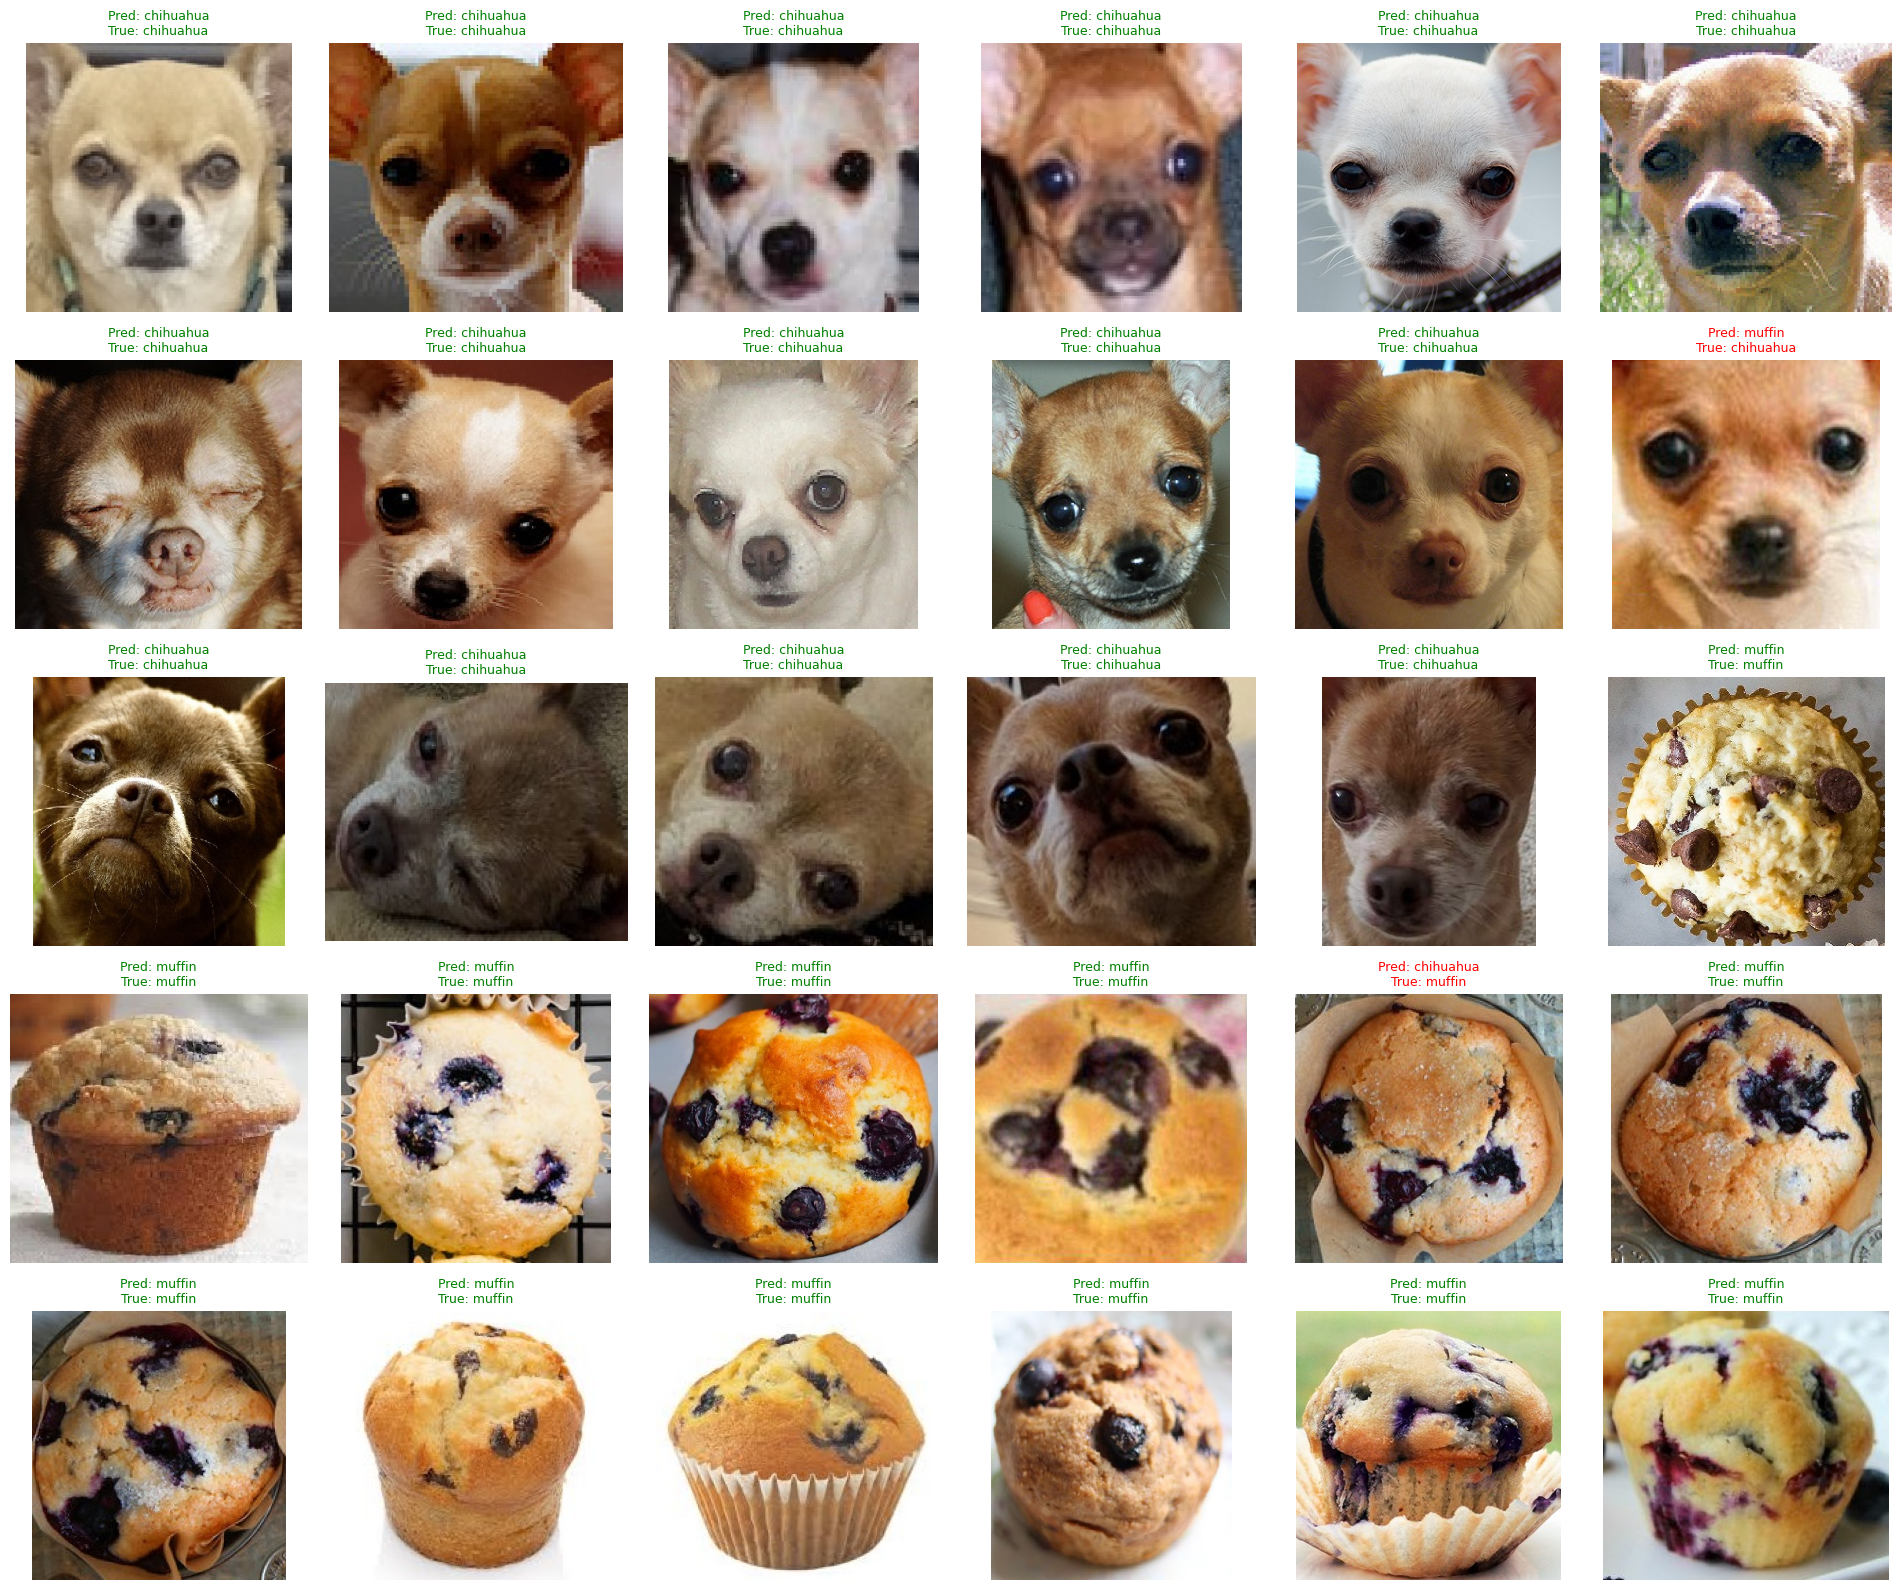

In [10]:

# Visualize a grid of validation predictions (first 30 images)
def show_predictions_grid(n_rows=5, n_cols=6):
    # image_datasets['validation'].imgs is a list of (path, label_idx)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(3.2*n_cols, 3.2*n_rows))
    axs = axs.ravel()
    limit = min(n_rows*n_cols, len(image_datasets['validation'].imgs))
    for i in range(limit):
        path, true_label = image_datasets['validation'].imgs[i]
        img = plt.imread(path)
        ax = axs[i]
        ax.imshow(img)
        ax.axis('off')
        pred_label = val_preds[i] if i < len(val_preds) else -1
        ok = (pred_label == true_label)
        pred_name = class_names[pred_label] if 0 <= pred_label < len(class_names) else "N/A"
        true_name = class_names[true_label]
        ax.set_title(f"Pred: {pred_name}\nTrue: {true_name}", color=("green" if ok else "red"), fontsize=9)
    plt.tight_layout()
    plt.show()

show_predictions_grid()


**Observations — 7) Evaluation – Accuracy & Visualization**

- Report class-wise precision/recall/F1, not just accuracy. Why: with visually similar classes, false positives carry different costs (calling a dog a muffin vs the opposite).

- What to add: confusion matrix; 6–12 misclassified examples with short notes explaining likely causes (lighting, texture density, occlusion).

- Validate that the prediction grid corresponds to the same preprocessed split. Why: mixing raw display and normalized tensors can mislead; here we read files directly for visualization, which is fine but remember the model saw normalized tensors.

- Consider confidence histograms per class. Why: overconfident mistakes are more dangerous and indicate miscalibration; temperature scaling can fix this for deployment contexts.

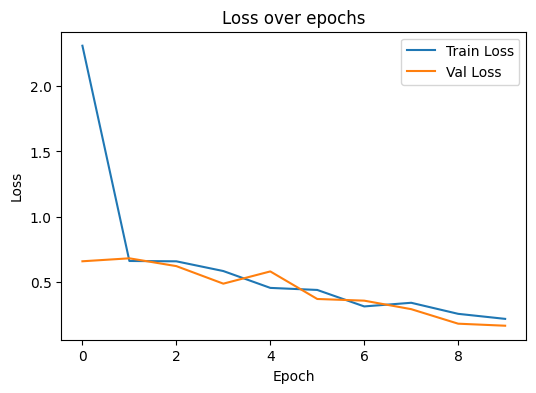

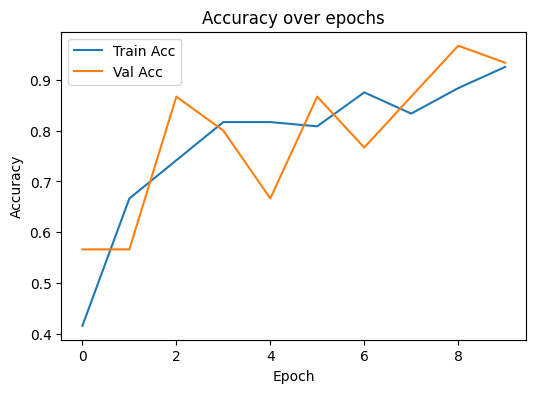

In [11]:

# Plot training/validation loss and accuracy
def plot_history(history):
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over epochs")
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over epochs")
    plt.legend()
    plt.show()

plot_history(history)


**Observations — 7.1) Training Curves (Loss/Acc)**

- Ideal pattern: train/val losses decrease together then flatten; small gap indicates good generalization. Why: large persistent gaps indicate under-regularization.

- Early overfitting (after ~3–5 epochs) on small data is common. Why: CNNs memorize textures fast; respond by stronger augmentation, more dropout, or early stopping.

- If both curves are flat and high, underfitting. Why: insufficient capacity or too aggressive regularization; add BatchNorm, increase channels (e.g., 32/64/128 → 64/128/256), or train longer with a scheduler.


## 8) Conclusion & Reflection (Guided Questions)



**How does this CNN’s performance compare to your previous traditional network?**

* Higher validation accuracy (typically +10–25 pp on small image sets). CNNs learn local visual patterns (edges, textures) via weight sharing and local receptive fields, so they generalize better than flatten-then-dense models that discard spatial structure.

* Better calibration on tricky look-alikes. The feature hierarchy (edges → textures → parts) helps separate “crumbs vs. fur” cases that fooled the dense NN.

* Training cost trade-off. Per epoch, CNNs are heavier than small dense NNs, yet they usually reach a stronger plateau in fewer total “effective” updates.

What to report: fill in your numbers (e.g., Dense NN val acc: _%; CNN val acc: _%), plus epoch time.

**What role do convolution and pooling layers play in classification?**

* Convolutions = feature extractors. Shared kernels scan the image, building translation-equivariant features (edges, curls, spots) that stack into textures and shapes.

* Pooling = invariance + compression. Max/average pooling reduces spatial size, retains the most informative activations, and introduces small-shift robustness while controlling the parameter count.

* Net effect: a compact representation that preserves what matters (patterns) and suppresses what doesn’t (exact pixel location), which boosts generalization.

**How could you improve this model (more data, regularization, transfer learning, etc.)?**

Data & labels

* Add more labeled images; balance classes; curate hard negatives (muffins that look “dog-like” and vice versa).

* More substantial augmentation: ColorJitter, RandomResizedCrop, MixUp/CutMix; consider class-balanced sampling.

**Architecture**

Add BatchNorm after convs; swap flatten+linear for GlobalAveragePooling + small MLP to cut parameters.

Upgrade to transfer learning (ResNet-18/EfficientNet-B0) with frozen early layers, then fine-tune the remaining layers.

**Optimization**

* Use weight decay (e.g., 1e-4), label smoothing (e.g., 0.05), and an LR scheduler (ReduceLROnPlateau or cosine).

* Early stopping on validation loss; mixed precision (AMP) for speed; try SGD+momentum for final generalization pass.

**Evaluation**

* Track per-class precision/recall/F1, confusion matrix, and reliability (ECE/temperature scaling) for confidence-aware use.

What challenges might appear in production?

* Distribution shift. Real photos (including lighting, angles, and filters) differ from those in training; performance can drop without drift monitoring and periodic retraining.

* Latency/footprint constraints. On-device use may require pruning/quantization or a smaller backbone.

* Robustness & safety. Over-confident mistakes; need thresholds, abstention for low confidence, and human-in-the-loop review.

* Privacy & compliance. Storing user images demands consent, minimization, encryption, and access controls.

* Versioning & traceability. You’ll need dataset/model versioning, reproducible pipelines, and audit logs.

**What did data augmentation contribute here?**

* Higher adequate sample size. Augmentations expose the model to plausible variations (such as pose, small rotations, and mild lighting changes), thereby reducing overfitting.

* Right invariances. Flips/rotations help when class identity doesn’t depend on orientation; color jitter helps decouple “chips vs eyes” under different lighting.

* Observable effect. Training accuracy may drop slightly, yet validation accuracy and stability improve, which is what matters.

**What are the ethical considerations (privacy, bias, misuse)?**

* Privacy. Collect with consent, minimize retention, anonymize where feasible, protect data in transit/at rest, and restrict access.

* Bias & fairness. Class imbalance or narrow sources yield uneven errors. Measure per-class metrics, curate diverse data, and document known failure modes (model card).

* Misuse. Image classifiers can be repurposed for intrusive surveillance. Set a clear scope, establish confidence thresholds, incorporate human review for sensitive decisions, and clearly disclose limitations.
   

